<img style="float: left;" src="images/unige_csd.png" alt="drawing" width="200"/>

# <center>Imagerie Numérique 2023 Automne</center>

<center>November 10, 2023</center>

# <center><ins>TP Class N°4 - Histograms and point operations</ins></center>

#### *Instructions :*  

* This TP should be completed and uploaded on Moodle before **Thursday 23 November 2023, 23h59**.
* The name of the file you upload should be **TP4_name_surname.ipynb**.
* If you need to include attached files to you TP, please archive them together in a folder named **TP4_name_surname.zip**.

### Import & util stuff

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import uint8 as u8, uint32 as u32, uint64 as u64, float64 as f64
from numpy.typing import NDArray
from PIL import Image
from copy import deepcopy
import skimage

FIG_SIZE = (20, 10)
FIG_SIZE_INV = (10, 20)


def imread(path: str, dtype: type = None, grayscale: bool = False) -> NDArray:
    """
    Load the image at given path into a numpy array
    @param path: path to image (relative to this file)
    @param dtype: if float, returned image will be in the [0, 1] range, else in [0, 255] (defaults to uint8)
    @param grayscale: whether to load image as grayscale or not
    @return: NDArray of shape (m, n, 3) if grayscale is False, else (m, n)
    """
    # img: Image = Image.open(path)
    # if grayscale: img = img.convert('L')
    # out = np.array(img)
    out: NDArray = plt.imread(path)
    if grayscale and len(out.shape) >= 3: out = skimage.color.rgb2gray(out)
    if dtype is None: return out

    img_max = np.max(out)
    is_img_float = img_max <= 1
    is_given_float = np.issubdtype(dtype, np.floating)
    if not is_given_float and is_img_float:
        out = u8(out * 255)
    elif is_given_float and not is_img_float:
        out = f64(out / 255.)
    return out


def imshow_gray(data, show=True, axis=True):
    plt.imshow(data, cmap="gray")
    plt.axis("on" if axis else "off")
    if show: plt.show()


def imshow(data, show=True, axis=True):
    plt.imshow(data)
    plt.axis("on" if axis else "off")
    if show: plt.show()


def MSE(im1, im2):
    return np.sum((im1 - im2) ** 2) / (im1.shape[0] * im1.shape[1])


def image_plot(idx: int, data, title=None, col=4, row=1, gray=True, vmax=None):
    plt.subplot(row, col, idx + 1)
    plt.title(title if title else "")
    plt.axis("off")
    plt.imshow(data, cmap="gray" if gray else None, vmin=0, vmax=vmax)
    if idx == (col * row): plt.show()


def bar_plot(idx: int, x, height, title=None, axis="off", col=4, row=1, color=None):
    plt.subplot(row, col, idx + 1)
    plt.title(title if title else "")
    plt.axis(axis)
    plt.bar(x, height, color=color)
    if idx == (col * row): plt.show()



--------------------------------------------

## Exercise 1. Exposure analysis

You are given 3 images: _img\_1.png_, _img\_2.png_ and _img\_3.png_.

(a) Plot the histograms of these images using the _histogram(.)_ function from the _skimage_ package.

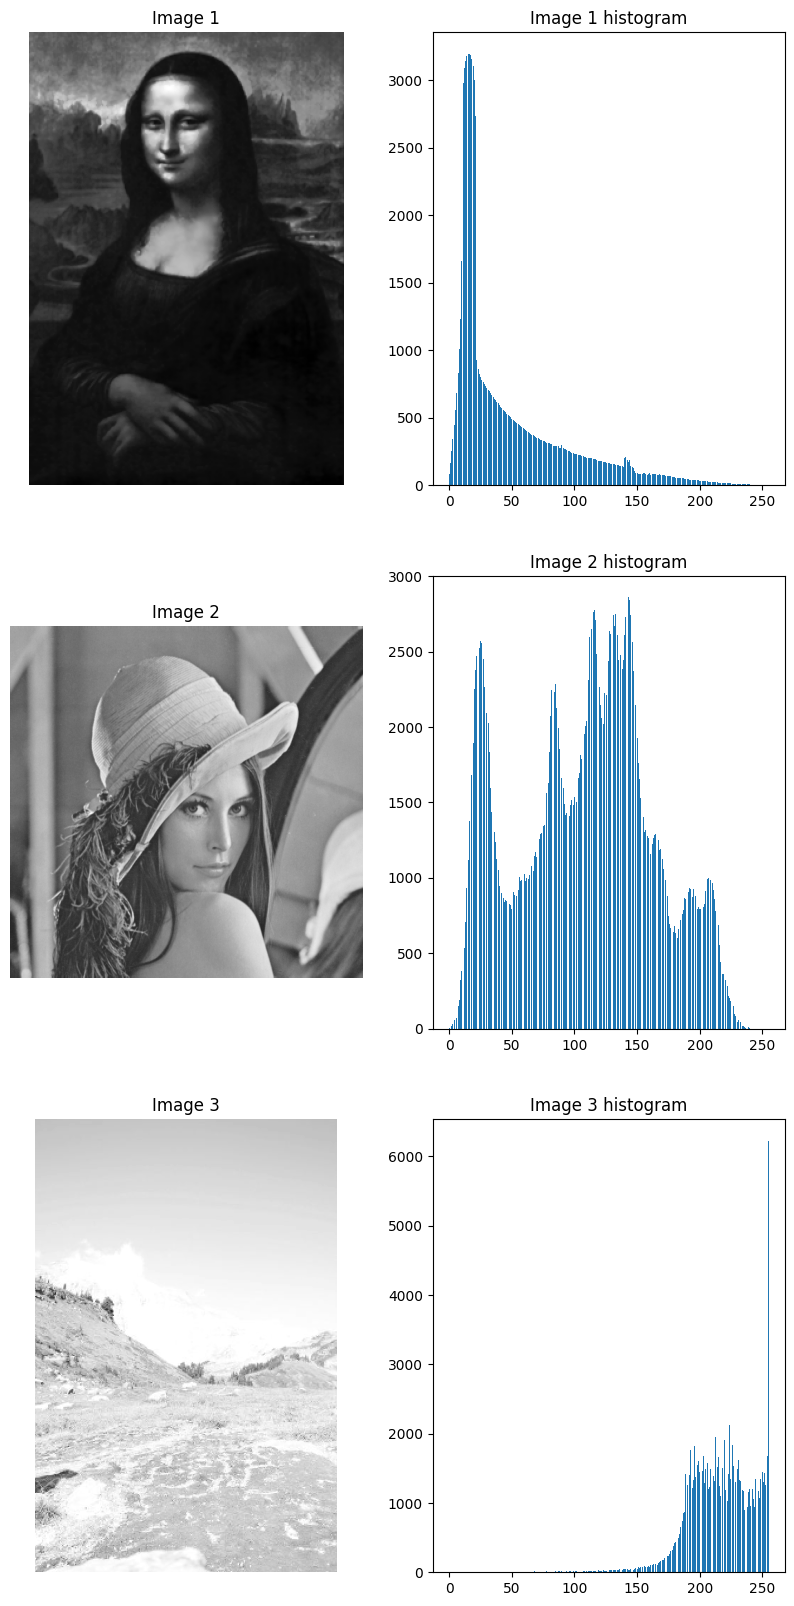

In [118]:
from skimage.exposure import histogram

HIST_X = np.arange(256)

images = [plt.imread(f'images/img_{i}.png') for i in (1, 2, 3)]

plt.figure(figsize=FIG_SIZE_INV)
for i, image in enumerate(images):
    image_plot(2 * i, image, title=f'Image {i + 1}', col=2, row=3)
    bar_plot(2 * i + 1, HIST_X, histogram(image, nbins=256)[0], title=f'Image {i + 1} histogram', col=2, row=3,
             axis="on")



(b) Try to detect if these images have problems with exposure. If yes, identify the reasons of these problems via histogram analysis.

Image 1 and image 3 have a problem with exposure. Image 1 is under-exposed and image 3 is over-exposed. 
The histogram isn't uniform, hence the whole dynamic range is not used.
We can see that the histogram of image 1 is shifted to the left and the histogram of image 3 is shifted to the right.

(c) Suggest an automatic procedure for detection of under/over-exposure in images.

Testing if the distance to the median is greater than a certain threshold could be a way to detect under/over-exposure. Because if we have a spike somewhere and nothing elsewhere the distance to the median would skyrocket for the spike.

## Exercise 2. Contrast analysis

You are given 3 images: _img\_4.png_, _img\_5.png_ and _img\_6.png_.

Detect and identify contrast problems in these images, if any. Justify your answer based on the analysis of the histograms.

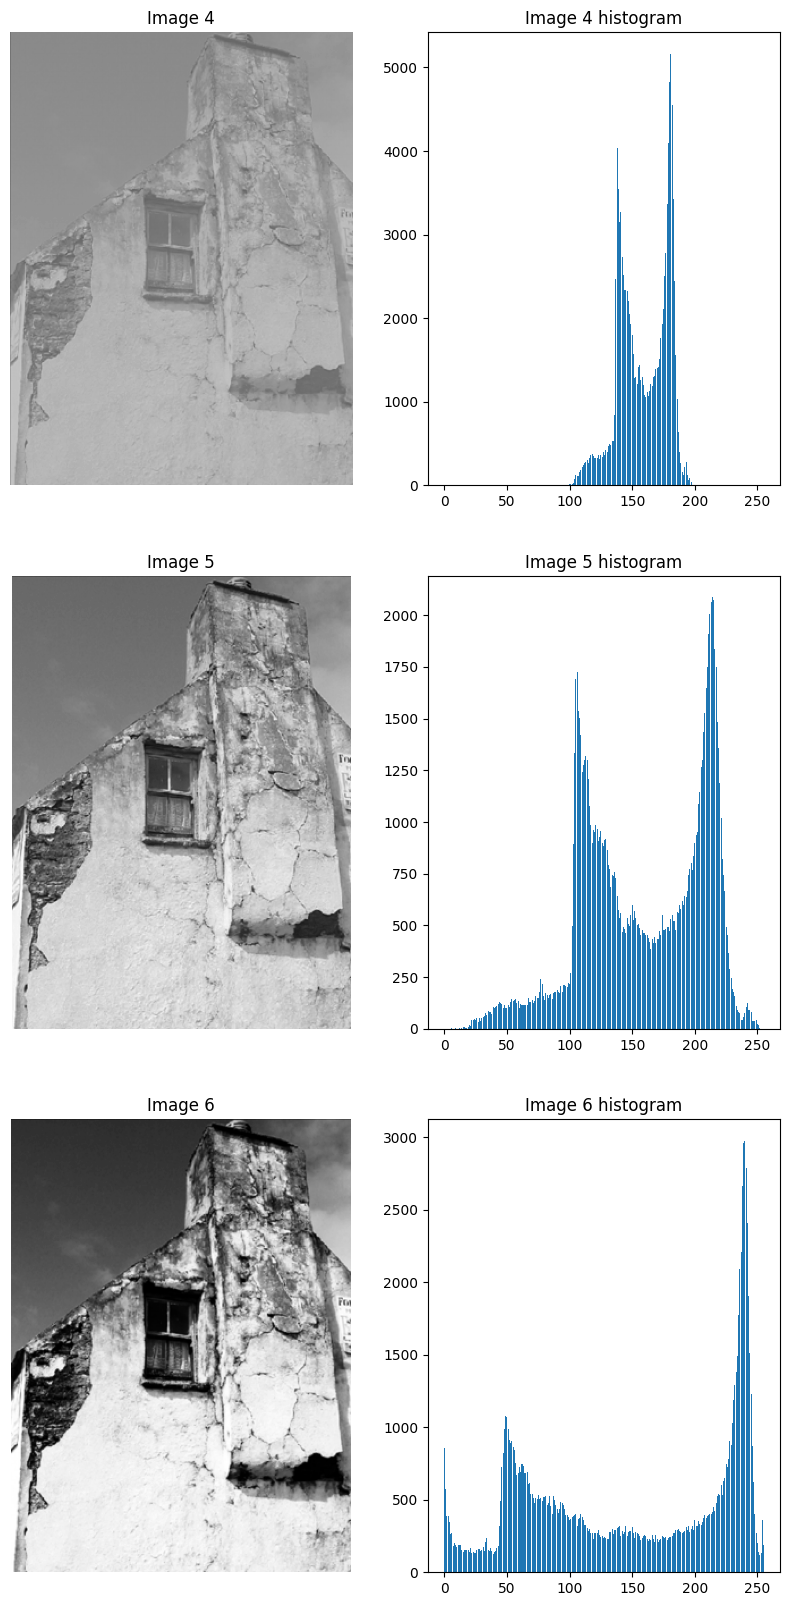

In [3]:
images = [(imread(f'images/img_{i}.png', dtype=u8)) for i in (4, 5, 6)]

#! WARN: histogram() ignores nbins if image is int

plt.figure(figsize=FIG_SIZE_INV)
for i, image in enumerate(images):
    image_plot(2 * i, image, title=f'Image {i + 4}', col=2, row=3, vmax=255)
    bar_plot(2 * i + 1, HIST_X, histogram(image, source_range="dtype")[0], title=f'Image {i + 4} histogram', col=2,
             row=3, axis="on")


The 2nd image looks the best, so we're going to use it as a reference.
The 1st image has a lower contrast, its histogram isn't uniform at all it would need to be widened. Furthermore, its histogram values are much higher, the mean value of 1st looks like the max of 2nd.
The 3rd image has a higher contrast, all the pixels are concentrated on the right i.e. towards the max value (black).


## Exercise 3. Contrast adjustment

**Important!** For color images, the histogram analysis should be performed individually on each color channel.

(a) Write a function that performs an image contrast adjustment (stretching). For more details see Theme 4.

In [77]:
def contrast_stretching(image: NDArray) -> NDArray:
    H, L = np.max(image), np.min(image)
    s = (image - L) / (H - L)
    return u8(s * 255) if image.dtype == u8 else s


(b) Apply your contrast adjustment function to the image _img 9.png_. Show image histogram before and after adjustment. Explain the result.

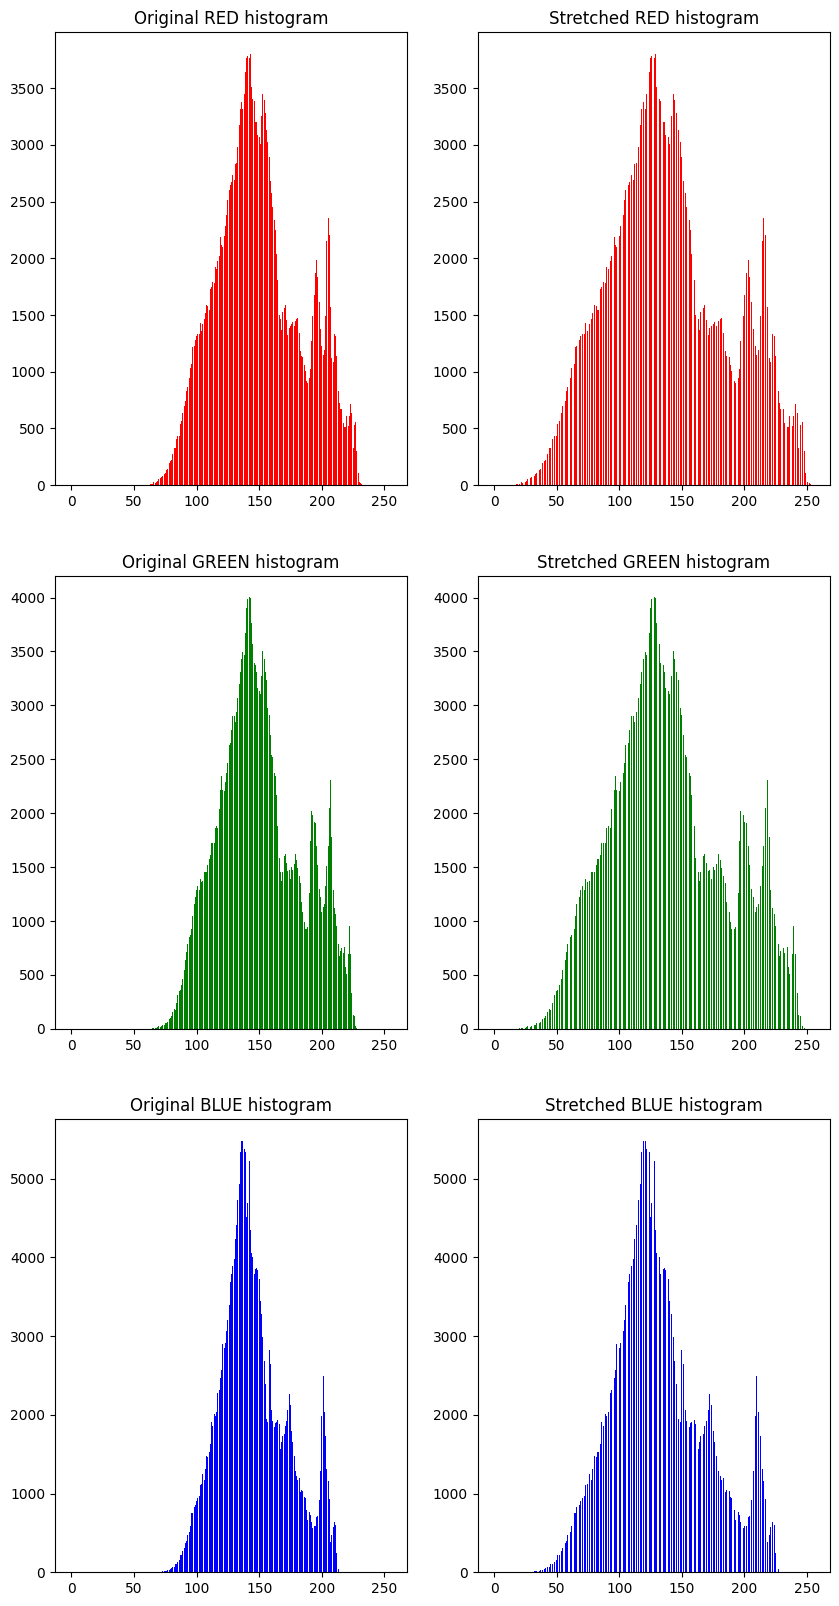

In [120]:
img9 = imread('images/img_9.png', dtype=u8)
img9_stretched = contrast_stretching(img9)
images = [img9, img9_stretched]

lbls = ["Original", "Stretched"]
chan = ["RED", "GREEN", "BLUE"]
colors = ["red", "green", "blue"]

plt.figure(figsize=FIG_SIZE_INV)
col, row = 2, 3
# for i, image in enumerate(images):
for j in range(3):
    for i in range(2):
        bar_plot(2 * j +  i, HIST_X, histogram(images[i][:, : , j], source_range="dtype")[0], title=f'{lbls[i]} {chan[j]} histogram', col=col, row=row, axis="on", color=colors[j])
        
plt.show()


(c) Apply the _rescale intensity(.)_ function from the _skimage_ package to the original image. Compare the result with the results of your function. Explain the differences in image quality, if any.

(d) Perform the sub-exercise (c) with _in_range_ parameter defined by using _np.percentile(.)_ with _q_ parameter equals to (5, 95). Explain the difference between (c) and (d).

> **Hint** : <br/>
start, end = np.percentile(image, (5, 95)) <br/>
adjusted image = rescale intensity(image, in range=(start, end))

## Exercise 4. Histogram equalization

(a) Perform histogram equalization to the image _img\_11.png_ by using _equalize\_hist(.)_ function from the _skimage_ package.

(b) Display the image histogram before and after equalization. Explain what the histogram equalization does.

## Exercise 5. Histogram matching

(a) Apply the function _match_histograms(.)_ from _skimage_ package to _img_4.png_ using _img_2.png_ as a reference.

(b) Display the histograms of _img_2.png_, _img_4.png_ before transformation and _img_4.png_ after transformation.

(c) Answer to the following questions:

• What does this function do ? <br/>
• How does this function work ? <br/>
• What can we use it for ?

> Answer here

## Exercise 6. Gamma Correction

(a) Write a function that performs image gamma correction. For more details see Theme 4.

(b) Apply your function to img 3.png, for various gamma values. Try to determine the gamma value that best improves the visual image quality.

(c) Visualize the image before and after correction. Explain the result.

## Exercise 7. Digital negatives

(a) Write a function that transforms an image into its digital negative.

(b) Choose 2 images from _img_1.png_ to _img_8.png_ and compute their digital negative. Visualize both the original and negative images.

(c) Explain in which situation this transformation could be useful.

> Answer here

## Exercise 8. Image masking

You are given the image _img_10.png_.

(a) Perform image thresholding to obtain a binary segmentation mask. Display the results for various choices of threshold values.

(b) Perform a pixel-wise multiplication between the original image and the various segmentation masks to obtain masked versions of the original image at different threshold. Display the results.

(c) Which threshold value works best for the segmentation of the statuette ?

> Answer here